# File and libraries

In [11]:
import pandas as pd
import numpy as np


filepath=r'dataset/df_ecom_2_6_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv" 

file_tag = "df_ecom_eval_RF"

# DSLabs functions

In [3]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [9]:
%run "data_functions.py"


data_functions loaded


# Load

In [14]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    sample=0.1
    df = df.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test = test.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train = train.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)


    
    
else:
    df=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # larger sample 10%
    sample=0.05
    df = df.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test = test.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train = train.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)

 
target='is_purchase'
vars: list[str] = df.columns.to_list()
labels: list = list(df[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12918 entries, 0 to 12917
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   category_code_lvl_1  12918 non-null  float64
 1   category_code_lvl_2  12918 non-null  float64
 2   price                12918 non-null  float64
 3   is_purchase          12918 non-null  int64  
 4   activity_in_session  12918 non-null  float64
 5   week_of_month        12918 non-null  int64  
 6   is_weekend           12918 non-null  int64  
 7   day                  12918 non-null  int64  
 8   brand_value          12918 non-null  float64
 9   product_category     12918 non-null  int64  
 10  time_of_day_sin      12918 non-null  float64
 11  time_of_day_cos      12918 non-null  float64
 12  day_of_week_sin      12918 non-null  float64
 13  day_of_week_cos      12918 non-null  float64
 14  hour_sin             12918 non-null  float64
 15  hour_cos             12918 non-null  floa

# Distribution Check

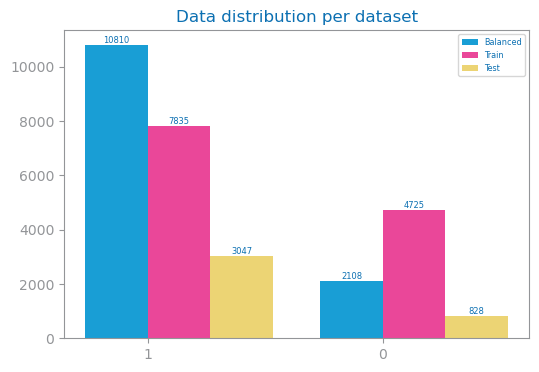

In [15]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Balanced": [
        len(df[df[target] == 0]),  # Assuming 0 is the negative class
        len(df[df[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

## Evaluate for best model - RForests

Train#=12560 Test#=3875
Labels=[0, 1]
RF best for 100 trees (d=5 and f=0.9)


<Figure size 640x480 with 0 Axes>

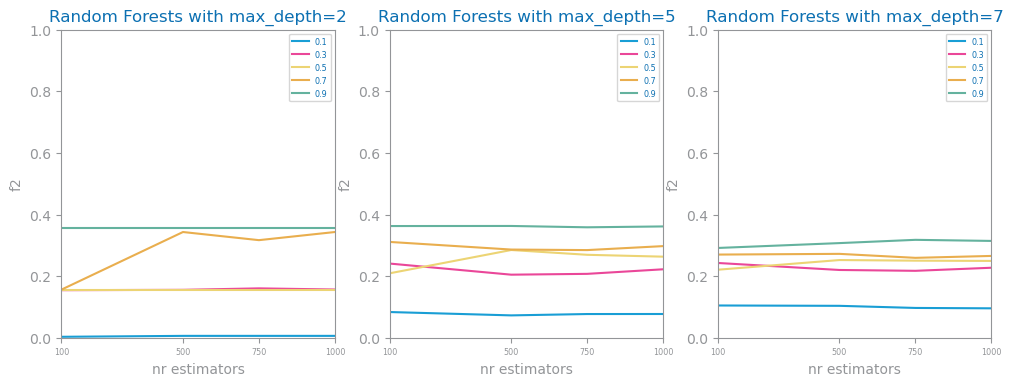

In [16]:
if evaluate==True:

    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')

    figure()

    eval_metric = 'f2'

    best_model, params = random_forests_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
    )
    
    savefig(f'images/{file_tag}_rf_{eval_metric}_study.png')
    show()
    

# Best Model Performance

<Figure size 640x480 with 0 Axes>

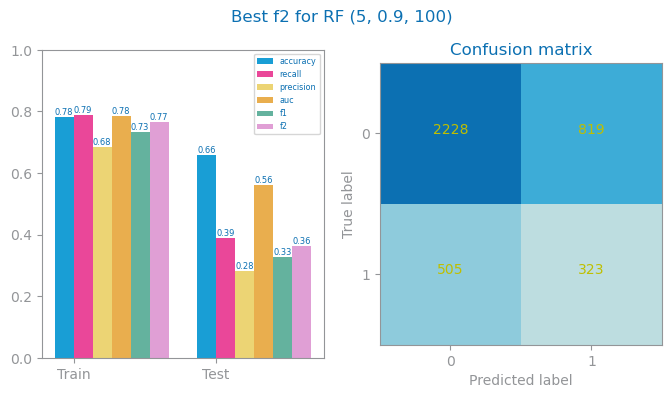

In [17]:
if evaluate == True:
    prd_trn: array = best_model.predict(trnX)
    prd_tst: array = best_model.predict(tstX)
    figure()
    plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
    savefig(f'images/{file_tag}_rf_{params["name"]}_best_{params["metric"]}_eval.png')
    show()

# Variables importance


1. day_of_week_sin (0.3070774561423179)
2. activity_in_session (0.2925537421164192)
3. day (0.1312010380290347)
4. hour_cos (0.08169586376362599)
5. day_of_week_cos (0.054244564548602124)
6. product_category (0.0342409734495375)
7. hour_sin (0.02686773654688402)
8. is_weekend (0.021262702702105063)
9. week_of_month (0.016188745089073583)
10. time_of_day_cos (0.011392502507973147)
11. min_sin (0.007298396713867477)
12. price (0.007199726098319308)
13. brand_value (0.004135340458991653)
14. time_of_day_sin (0.0019575797430753414)
15. category_code_lvl_2 (0.0016728251390472175)
16. min_cos (0.0008490647721076367)
17. category_code_lvl_1 (0.0001617421790180892)


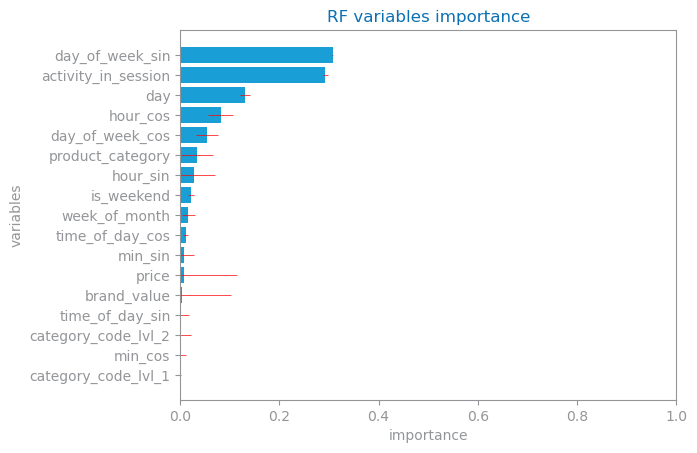

In [18]:
if evaluate==True:
    from numpy import std, argsort
    from dslabs_functions import plot_horizontal_bar_chart

    stdevs: list[float] = list(
        std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
    )
    importances = best_model.feature_importances_
    indices: list[int] = argsort(importances)[::-1]
    elems: list[str] = []
    imp_values: list[float] = []
    for f in range(len(vars)):
        elems += [vars[indices[f]]]
        imp_values.append(importances[indices[f]])
        print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

    figure()
    plot_horizontal_bar_chart(
        elems,
        imp_values,
        error=stdevs,
        title="RF variables importance",
        xlabel="importance",
        ylabel="variables",
        percentage=True,
    )
    savefig(f"images/{file_tag}_rf_{eval_metric}_vars_ranking.png")

# Overfitting

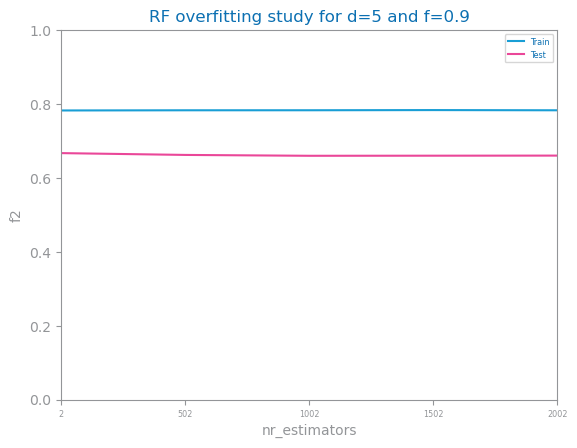

In [19]:
if evaluate==True:
    
    d_max: int = params["params"][0]
    feat: float = params["params"][1]
    nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

    y_tst_values: list[float] = []
    y_trn_values: list[float] = []
    acc_metric: str = "accuracy"

    for n in nr_estimators:
        clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
        clf.fit(trnX, trnY)
        prd_tst_Y: array = clf.predict(tstX)
        prd_trn_Y: array = clf.predict(trnX)
        y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
        y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

    figure()
    plot_multiline_chart(
        nr_estimators,
        {"Train": y_trn_values, "Test": y_tst_values},
        title=f"RF overfitting study for d={d_max} and f={feat}",
        xlabel="nr_estimators",
        ylabel=str(eval_metric),
        percentage=True,
    )
    savefig(f"images/{file_tag}_rf_{eval_metric}_overfitting.png")

# Analysis

- Traffic source and medium with higher importance
- overfitting from level 3
